# Class Activation Map for Explaining Data Series Classification

In this Notebook we build a synthetic example data series collection in order to illustrate the ability of Class Activation Map (CAM) to identifty abnormal temporal window in time series.

For that purpose, we use the StarLightCurve dataset provided in the UCR archive. This dataset is composed of data series measuring the light intensity of a given star through time. The light change when an event occurs. This event can be a planet crossing the star (Class 2). 

### Multivariate test

In our example, we build ong data series composed of 10 concatenated patterns of the LightCurve dataset. Our two classes are built as follow:

- **Class 1**: We concatenate 10 randomly selected patterns from StarLightCurve class 3 for all of the dimensions
- **Class 2**: We concatenate 9 randomly selected patterns from StarLightCurve Class 3 plus 1 randomly selected pattern from class 2 (added at a random position) on only one of the dimensions.

We expect Class Activation Map to point the StarLightCurve class 1 pattern (its temporal position) as an explaination of the classification.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from random import randint
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm

In [3]:
sys.path.insert(0, '../src/models')
sys.path.insert(0, '../src/explanation')

from CNN_models import *
from CAM import *

## Function for synthetic dataset construction
### Parameters

In [4]:
# Number of instance of Class 1 to concatenate on each dimension
nb_seq = 8
# Number of dimensions
nb_dim = 5
# Number of instance per class
nb_instance = 300
# train-test ratio
train_test_r = 0.75

### Functions

In [5]:

def generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_set=None,side=0):
    result = []
    rand_side = side
    if pos_anom_set is not None:
        pos_anom = pos_anom_set
    else:
        pos_anom = randint(0,nb_seq-1)
    for i in range(nb_seq):
        if i == pos_anom:
            if rand_side == 1:
                result += list(np.array(all_class_2[randint(0,len(all_class_2)-1)]))
            elif rand_side == 0:
                result += [cl2 for cl2 in all_class_2[randint(0,len(all_class_2)-1)]]
        else:
            result += all_class_1[randint(0,len(all_class_1)-1)]
    if side == 0:
        return [res for i,res in enumerate(result) if i % 15 == 0]
    else:
        return [res for i,res in enumerate(result) if i % 15 == 0]
        
def generate_normal(nb_seq,all_class_1,side=0):
    result = []
    for i in range(nb_seq):
        result += all_class_1[randint(0,len(all_class_1)-1)]
    if side == 0:
        return [res for i,res in enumerate(result) if i % 15 == 0]
    else:
        return [res for i,res in enumerate(result) if i % 15 == 0]
        
def generate_multivaraite_norm(nb_dim,nb_seq,all_class_1):
    instance = []
    for i in range(nb_dim):
        instance.append(generate_normal(nb_seq,all_class_1,side = i%2))
    return instance,[]

def generate_multivaraite_abnormal(nb_dim,nb_seq,all_class_1,all_class_2,nb_k=2):
    instance = []
    all_rand_pos = []
    for i in range(nb_k):
        rand_pos = randint(0,nb_dim-1)
        while (rand_pos in all_rand_pos):
            rand_pos = randint(0,nb_dim-1)
        all_rand_pos.append(rand_pos)
    groundtruth = []
    all_pos_anom = []
    for i in range(nb_k):
        pos_anom = randint(0,nb_seq-1)
        while pos_anom in all_pos_anom: 
            pos_anom = randint(0,nb_seq-1)
        all_pos_anom.append(pos_anom)
    for i in range(nb_dim):
        found = False
        for rand_pos_2,pos_anom_2 in zip(all_rand_pos,all_pos_anom):
            if rand_pos_2 == i:
                instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_2,side = i%2))#randint(0,1)))
                anom_length = len(all_class_1[0])//15 + 1
                groundtruth.append([0]*(anom_length*pos_anom_2) + [1]*anom_length + [0]*((nb_seq - pos_anom_2-1)*anom_length))
                found = True
                break
        if not found:
            instance.append(generate_normal(nb_seq,all_class_1,side = i%2))#randint(0,1)))
            groundtruth.append([0]*len(instance[-1]))
    return instance,groundtruth

def generate_multivaraite_abnormal_same(nb_dim,nb_seq,all_class_1,all_class_2):
    instance = []
    rand_pos = 1
    rand_pos_2 = 8
    while (rand_pos_2 == rand_pos):
        rand_pos_2 = randint(0,nb_dim-1)
    pos_anom_1 = randint(0,nb_seq-1)
    pos_anom_2 = randint(0,nb_seq-1)
    while pos_anom_2 ==  pos_anom_1: 
        pos_anom_2 = randint(0,nb_seq-1)
    for i in range(nb_dim):
        if i == rand_pos:
            instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_1,side=0))
        elif rand_pos_2 == i:
            instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_2,side=1))
        else:
            instance.append(generate_normal(nb_seq,all_class_1))
    return instance


def generate_multivaraite_abnormal_sync(nb_dim,nb_seq,all_class_1,all_class_2,nb_k=2):
    instance = []
    all_rand_pos = []
    for i in range(nb_k):
        rand_pos = randint(0,nb_dim-1)
        while (rand_pos in all_rand_pos):
            rand_pos = randint(0,nb_dim-1)
        all_rand_pos.append(rand_pos)
    groundtruth = []
    pos_anom_2 = randint(0,nb_seq-1)
    for i in range(nb_dim):
        found = False
        for rand_pos_2 in all_rand_pos:
            if rand_pos_2 == i:
                instance.append(generate_anomaly(nb_seq,all_class_1,all_class_2,pos_anom_2,side = i%2))#randint(0,1)))
                anom_length = len(all_class_1[0])//15 + 1
                groundtruth.append([0]*(anom_length*pos_anom_2) + [1]*anom_length + [0]*((nb_seq - pos_anom_2-1)*anom_length))
                found = True
                break
        if not found:
            instance.append(generate_normal(nb_seq,all_class_1,side = i%2))#randint(0,1)))
            groundtruth.append([0]*len(instance[-1]))
    return instance,groundtruth

def gen_cube(instance):
    result = []
    for i in range(len(instance)):
        result.append([instance[(i+j)%len(instance)] for j in range(len(instance))])
    return result

### Reading the dataset

In [6]:
df = pd.read_csv("../data/examples/data.tsv",sep='\t',header=None)

all_class_1 = []
all_class_2 = []
for index in range(len(df)):
    to_add = (df.values[index][1:] - np.mean(df.values[index][1:]))/(np.std(df.values[index][1:]))
    if df.values[index][0] == 3.0: 
        all_class_1.append(list(to_add))
    elif df.values[index][0] == 2.0: 
        all_class_2.append(list(to_add))

### Building our Synthetic Dataset

In [7]:
#Anomaly Type 1

Class1 = [generate_multivaraite_norm(nb_dim,nb_seq,all_class_1)[0] for j in range(nb_instance)]
Class2 = [generate_multivaraite_abnormal(nb_dim,nb_seq,all_class_1,all_class_2)[0] for j in range(nb_instance)]

#Anomaly Type 2

#Class1 = [generate_multivaraite_abnormal(nb_dim,nb_seq,all_class_1,all_class_2) for j in range(nb_instance)]
#Class2 = [generate_multivaraite_abnormal_sync(nb_dim,nb_seq,all_class_1,all_class_2) for j in range(nb_instance)]

### Class 2 instance Visualization 

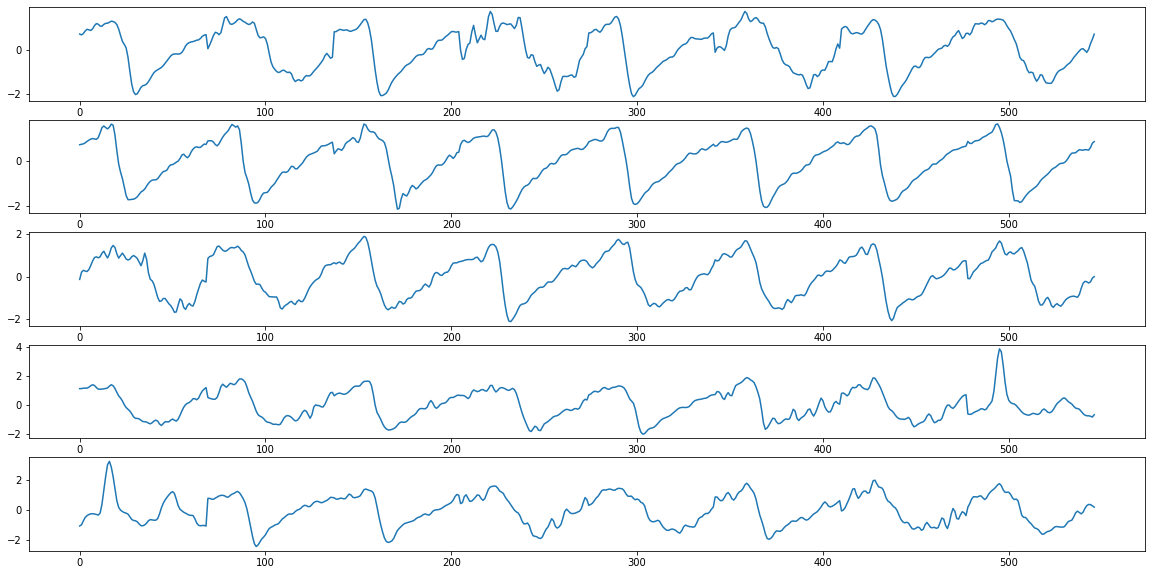

In [8]:
plt.figure(figsize=(20,10))
for i in range(len(Class1[1])):
    plt.subplot(len(Class1[1]),1,1+i)
    plt.plot(Class2[8][i])

### Training Parameter

In [9]:
# training parameter
device='cpu'
original_length = len(Class1[0][0])
num_classes = 2
batch_size = 32
original_dim = nb_dim

### Generate pyTorch-like datasets 

We keep the training set small for this example.

In [10]:
label = [1]*100 + [0]*100
label_test = [1]*24 + [0]*24

label = np.array(label)
label_test = np.array(label_test)

all_class = Class1[:100] + Class2[:100]
all_class_test = Class1[100:124] + Class2[100:124]

all_class = np.array([acl for acl in all_class])
all_class_test = np.array([acl for acl in all_class_test])

x = all_class
dataset_mat = TSDataset(x,label)
dataloader_cl1 = data.DataLoader(dataset_mat, batch_size=batch_size, shuffle=True)

x = all_class_test
dataset_mat_test = TSDataset(x,label_test)
dataloader_cl1_test = data.DataLoader(dataset_mat_test, batch_size=1, shuffle=True)

# Training the model

### Training the model

In [13]:
#CNN
#modelarch = ConvNet(original_length,original_dim,num_classes).to(device)
#Resnet
#modelarch = ResNetBaseline(original_dim,mid_channels=64,num_pred_classes=num_classes).to(device)
#InceptionTime
modelarch = InceptionModel(num_blocks=3, in_channels=original_dim, out_channels=32,
                            bottleneck_channels=32, kernel_sizes=[10,20,40],
                            use_residuals=True, num_pred_classes=num_classes).to(device)

model = ModelCNN(modelarch,device)
summary(model.model.to(device),input_size=(original_dim,original_length))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 Conv1dSamePadding-1              [-1, 32, 547]             160
 Conv1dSamePadding-2              [-1, 32, 547]          10,240
 Conv1dSamePadding-3              [-1, 32, 547]           5,120
 Conv1dSamePadding-4              [-1, 32, 547]           2,048
 Conv1dSamePadding-5              [-1, 32, 547]             160
       BatchNorm1d-6              [-1, 32, 547]              64
              ReLU-7              [-1, 32, 547]               0
    InceptionBlock-8              [-1, 32, 547]               0
 Conv1dSamePadding-9              [-1, 32, 547]           1,024
Conv1dSamePadding-10              [-1, 32, 547]          20,480
Conv1dSamePadding-11              [-1, 32, 547]          10,240
Conv1dSamePadding-12              [-1, 32, 547]           5,120
Conv1dSamePadding-13              [-1, 32, 547]           1,024
      BatchNorm1d-14              [-1, 

In [14]:
model.train(num_epochs=500,dataloader_cl1=dataloader_cl1,dataloader_cl1_test=dataloader_cl1_test)

Epoch [1/500], Loss Train: 0.6964,Loss Test: 0.6937, Accuracy Train: 50.00%, Accuracy Test: 50.00%
Epoch [11/500], Loss Train: 0.6813,Loss Test: 0.6760, Accuracy Train: 64.50%, Accuracy Test: 70.83%
Epoch [21/500], Loss Train: 0.6743,Loss Test: 0.6692, Accuracy Train: 67.50%, Accuracy Test: 77.08%
Epoch [31/500], Loss Train: 0.6695,Loss Test: 0.6619, Accuracy Train: 77.00%, Accuracy Test: 83.33%
Epoch [41/500], Loss Train: 0.6578,Loss Test: 0.6509, Accuracy Train: 72.50%, Accuracy Test: 85.42%
Epoch [51/500], Loss Train: 0.6422,Loss Test: 0.6301, Accuracy Train: 72.00%, Accuracy Test: 77.08%
Epoch [61/500], Loss Train: 0.6015,Loss Test: 0.5826, Accuracy Train: 73.50%, Accuracy Test: 79.17%
Epoch [71/500], Loss Train: 0.5485,Loss Test: 0.5095, Accuracy Train: 72.00%, Accuracy Test: 79.17%
Epoch [81/500], Loss Train: 0.5163,Loss Test: 0.4550, Accuracy Train: 71.00%, Accuracy Test: 83.33%
Epoch [91/500], Loss Train: 0.4916,Loss Test: 0.4395, Accuracy Train: 75.00%, Accuracy Test: 79.17%
E

### Train and test loss (Binary Cross Entropy) versus Epoch  

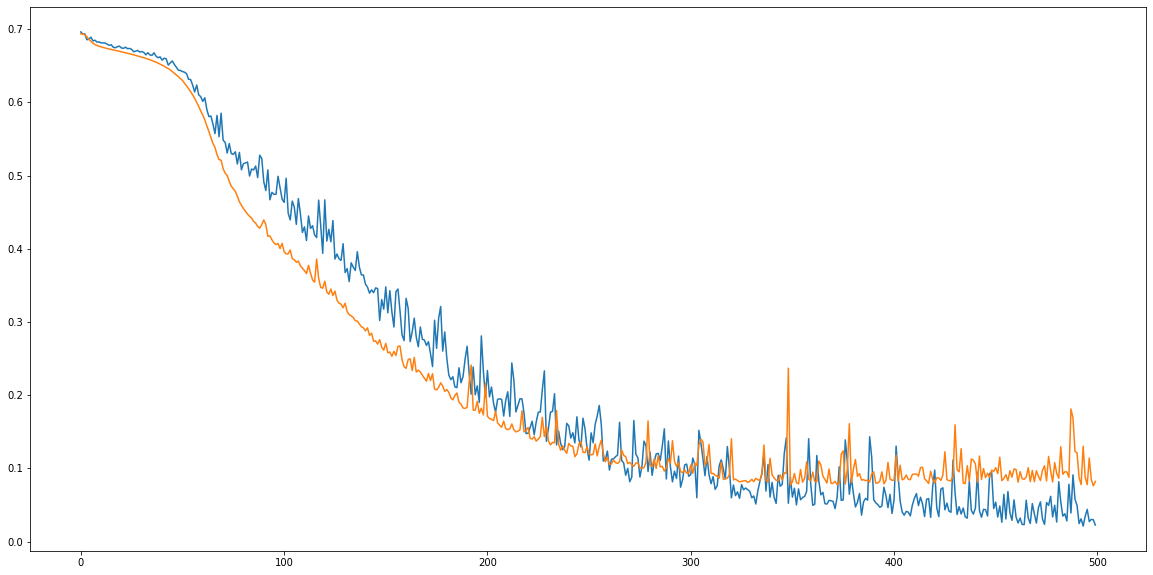

In [15]:
plt.figure(figsize=(20,10))
plt.plot(model.loss_train_history)
plt.plot(model.loss_test_history)

# d-CAM Class Activation Map


In [17]:
model = torch.load("model").to(device)
model = model.eval()

instance = Class2[230]
label_instance = 0

#CNN
#last_conv_layer = model._modules['layer3']
#fc_layer_name = model._modules['fc1']

#ResNet
#last_conv_layer = model._modules['layers'][2]
#fc_layer_name = model._modules['final']


#InceptionTime
last_conv_layer = model._modules['blocks'][2]
fc_layer_name = model._modules['linear']


CAM = CAM(model,device,last_conv_layer=last_conv_layer,fc_layer_name=fc_layer_name)


cam = CAM.run(instance=instance,label_instance=label_instance)

../src/explanation/CAM.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


Text(0.5, 1.0, 'Class Activation Map')

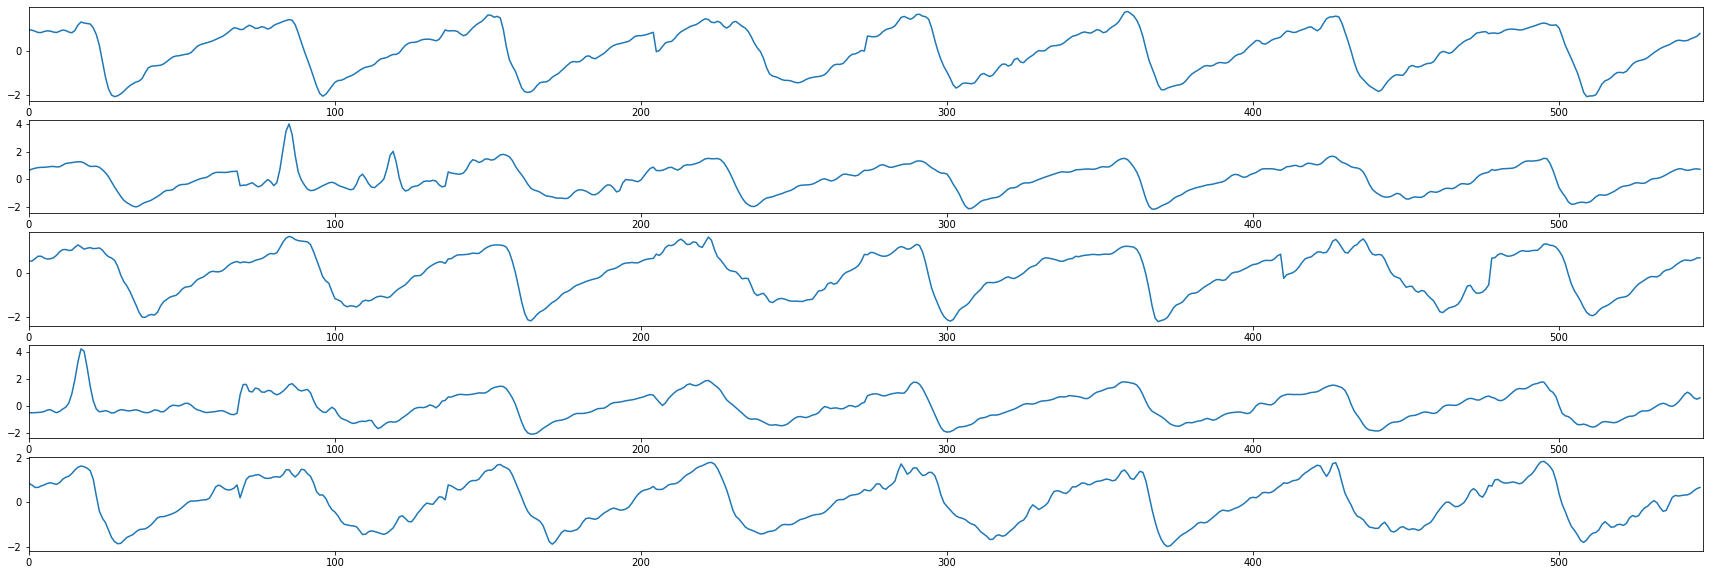

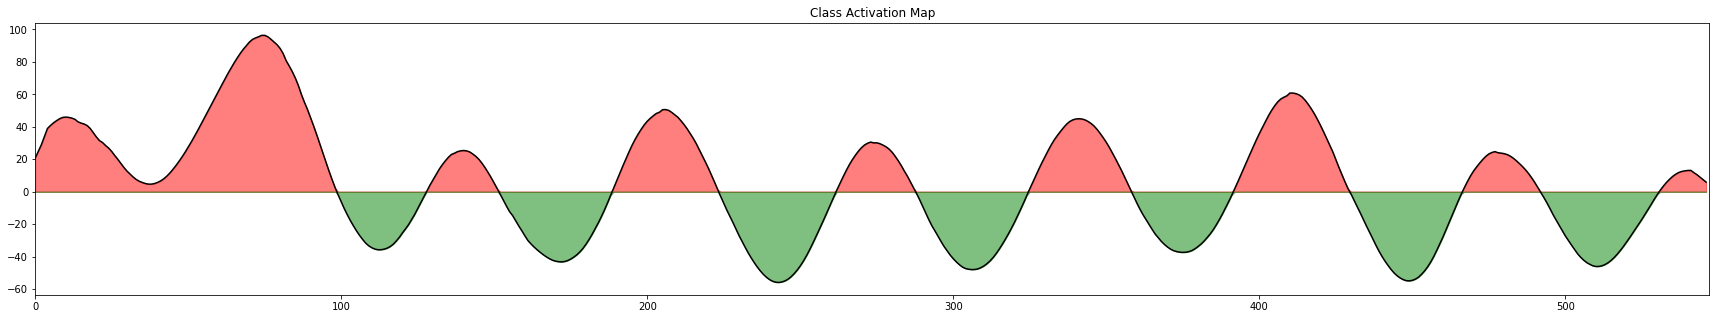

In [18]:
def fmax(val):
    if val > 0 : return val
    else: return 0
def fmin(val):
    if val < 0 : return val
    else: return 0

plt.figure(figsize=(30,10))
for i in range(len(instance)):
    plt.subplot(len(instance),1,1+i)
    plt.plot(instance[i])
    plt.xlim(0,len(cam))
fig,ax = plt.subplots(1,1,figsize=(30,5))
plt.plot(cam,color='black')
plt.fill_between(list(range(len(cam))),[fmax(val) for val in cam],color='red',alpha=0.5)
plt.fill_between(list(range(len(cam))),[fmin(val) for val in cam],color='green',alpha=0.5)
plt.xlim(0,len(cam))
plt.title('Class Activation Map')
